## Implementación de un recomendador de aperturas usando redes neuronales

# Instalación de dependencias

In [ ]:
!pip install tensorflow imbalanced-learn joblib python-chess chardet

# Importación de librerías

In [ ]:
import chess.pgn
import io
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files
import chardet
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict

# Clase principal del recomendador

In [62]:
class OpeningRecommender:
    def __init__(self):

        self.opening_mapping = {
            'Catalana': {'style': 'posicional'},
            'Inglesa': {'style': 'posicional'},
            'Londres': {'style': 'posicional'},
            'Escocesa': {'style': 'combinativo'},
            'Gambito_de_Rey': {'style': 'combinativo'},
            'Gambito_Danes': {'style': 'combinativo'},
            'Italiana': {'style': 'universal'},
            'Española': {'style': 'universal'},
            'Gambito_de_Dama': {'style': 'universal'}
        }

        self.style_spanish_mapping = {
            'positional': 'posicional',
            'combinative': 'combinativo',
            'universal': 'universal'
        }

        self.scaler = StandardScaler()
        self.opening_encoder = LabelEncoder()
        self.style_encoder = LabelEncoder()

        opening_names = list(self.opening_mapping.keys())
        self.opening_encoder.fit(opening_names)

        styles = list({v['style'] for v in self.opening_mapping.values()})
        self.style_encoder.fit(styles)

        self.model = None

    def _build_recommendation_model(self, input_shape, num_openings):
        """Construye la red neuronal para recomendación de aperturas"""
        model = Sequential([
            Dense(256, activation='relu', input_shape=(input_shape,)),
            Dropout(0.4),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(num_openings, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.0008),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def process_pgns(self):
        """Procesa archivos PGN usando el nombre del archivo como fuente de la apertura"""
        features = []
        opening_labels = []
        styles = []
        uploaded = files.upload()

        for filename, content in uploaded.items():
            try:
                # Extraer nombre de apertura del archivo (ej: "Catalana.pgn" -> "Catalana")
                opening_name = os.path.splitext(filename)[0].replace(' ', '_')
                if opening_name not in self.opening_mapping:
                    print(f"[!] Archivo {filename} no corresponde a apertura conocida")
                    continue

                print(f"Se esta analizando las partidas de la apertura {filename}")

                # Obtener estilo asociado a la apertura
                opening_style = self.opening_mapping[opening_name]['style']

                # Detectar codificación
                enc = chardet.detect(content)['encoding'] or 'latin-1'
                pgn_text = content.decode(enc, errors='replace')
                pgn = io.StringIO(pgn_text)

                while True:
                    game = chess.pgn.read_game(pgn)
                    if not game:
                        break

                    # Extraer características técnicas y de estilo
                    game_features = self._extract_game_features(game, opening_style)
                    if game_features:
                        features.append(game_features)
                        opening_labels.append(opening_name)
                        styles.append(opening_style)

                print(f"Se terminó de analizar las partidas de la apertura {filename}")

            except Exception as e:
                print(f"Error procesando {filename}: {str(e)}")
                continue

        if not features:
            print("No hay datos válidos para entrenar")
            return False

        # Preprocesamiento
        print("Inicio el preprocesamiento")
        self.X = np.array(features)
        self.y = self.opening_encoder.transform(opening_labels)
        self.y_onehot = to_categorical(self.y)

        # Escalar características
        print("Inicio el escalamiento")
        self.scaler.fit(self.X)
        self.X = self.scaler.transform(self.X)

        # Balancear datos
        print("Inicio el balanceo de datos")
        adasyn = ADASYN(n_neighbors=2)
        self.X, self.y = adasyn.fit_resample(self.X, self.y)
        self.y_onehot = to_categorical(self.y)

        print(f"\nDatos procesados: {len(self.X)} partidas")
        print("Distribución de aperturas:", dict(zip(
            self.opening_encoder.inverse_transform(np.unique(self.y)),
            np.bincount(self.y)
        )))

        # Construir modelo
        self.model = self._build_recommendation_model(
            self.X.shape[1],
            len(self.opening_encoder.classes_)
        )
        return True

    def _extract_game_features(self, game, style):
        """Extrae características técnicas + estilo como input"""
        MOVES_TO_ANALYZE = 30
        FEATURES_PER_MOVE = 8
        STYLE_FEATURES = 3
        TOTAL_FEATURES = MOVES_TO_ANALYZE * FEATURES_PER_MOVE + STYLE_FEATURES

        board = game.board()
        features = []
        moves_analyzed = 0

        try:
            # One-hot encoding del estilo
            style_encoded = self.style_encoder.transform([style])[0]
            style_onehot = [0] * STYLE_FEATURES
            style_onehot[style_encoded] = 1

            for move in game.mainline_moves():
                board.push(move)
                if moves_analyzed >= MOVES_TO_ANALYZE:
                    break

                # 1. Control del centro
                center_control = sum(1 for sq in [chess.D4, chess.D5, chess.E4, chess.E5]
                                    if board.is_attacked_by(chess.WHITE, sq))

                # 2. Desarrollo de piezas
                knights = [sq for sq in board.pieces(chess.KNIGHT, chess.WHITE)
                          if sq not in [chess.B1, chess.G1]]
                bishops = [sq for sq in board.pieces(chess.BISHOP, chess.WHITE)
                          if sq not in [chess.C1, chess.F1]]
                piece_development = len(knights + bishops)

                # 3. Enroque
                castling = 1 if board.has_castling_rights(chess.WHITE) else 0

                # 4. Avance de peones
                pawn_advance = sum(chess.square_rank(sq) for sq in board.pieces(chess.PAWN, chess.WHITE))

                # 5. Actividad de la dama
                queen_squares = board.pieces(chess.QUEEN, chess.WHITE)
                queen_active = 1 if queen_squares and next(iter(queen_squares)) not in [chess.D1, chess.E1] else 0

                # 6. Balance material
                material_balance = (
                    len(board.pieces(chess.PAWN, chess.WHITE)) * 1 +
                    len(board.pieces(chess.KNIGHT, chess.WHITE)) * 3 +
                    len(board.pieces(chess.BISHOP, chess.WHITE)) * 3 +
                    len(board.pieces(chess.ROOK, chess.WHITE)) * 5 +
                    len(board.pieces(chess.QUEEN, chess.WHITE)) * 9
                )

                # 7. Columnas abiertas
                open_files = 0
                for file_index in range(8):
                    file_mask = chess.BB_FILES[file_index]
                    white_pawns = board.pieces(chess.PAWN, chess.WHITE) & file_mask
                    black_pawns = board.pieces(chess.PAWN, chess.BLACK) & file_mask
                    if not white_pawns and not black_pawns:
                        open_files += 1

                # 8. Complejidad posicional
                position_complexity = len(list(board.legal_moves))

                features.extend([
                    center_control,
                    piece_development,
                    castling,
                    pawn_advance,
                    queen_active,
                    material_balance,
                    open_files,
                    position_complexity
                ])
                moves_analyzed += 1

            # Asegurar longitud fija
            current_length = len(features)
            if current_length < TOTAL_FEATURES - STYLE_FEATURES:
                features += [0] * (TOTAL_FEATURES - STYLE_FEATURES - current_length)
            features = features[:TOTAL_FEATURES - STYLE_FEATURES]

            # Agregar características de estilo
            features += style_onehot
            return features
        except Exception as e:
            print(f"Error en extracción: {str(e)}")
            return None

    def train_model(self):
        """Entrena el modelo"""
        if not hasattr(self, 'X') or not hasattr(self, 'y_onehot'):
            print("Primero debe procesar datos con process_pgns()")
            return
        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            self.y_onehot,
            test_size=0.2,
            random_state=42
        )
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.0001
        )
        history = self.model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluación final
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        y_pred = self.model.predict(X_test)
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f"\nPrecisión final en test: {accuracy*100:.2f}%")
        self._plot_training_history(history, conf_matrix)

    def recommend_for_pgn(self, pgn_text, player_style=None):
        """Recomienda aperturas basadas en un PGN de partida y estilo de jugador"""

        try:
            if player_style and player_style not in self.style_spanish_mapping.values():
                return f"Estilo '{player_style}' no válido. Opciones: {list(self.style_spanish_mapping.values())}"

            # Procesar PGN
            pgn = io.StringIO(pgn_text)
            game = chess.pgn.read_game(pgn)
            if not game:
                return "Error: No se pudo leer el PGN"

            features = self._extract_game_features(game, player_style)
            if not features:
                return "Error: No se pudieron extraer características"

            scaled_features = self.scaler.transform([features])

            # Predecir probabilidades
            prediction = self.model.predict(scaled_features, verbose=0)[0]

            opening_names = list(self.opening_mapping.keys())
            recommendations = []
            for idx, prob in enumerate(prediction):
                opening = opening_names[idx]
                if opening not in self.opening_mapping:
                    continue
                recommendations.append({
                    'apertura': opening,
                    'estilo': self.opening_mapping[opening]['style'],
                    'probabilidad': float(prob),
                    'ponderacion' : 0.00
                })

            recommendations.sort(key=lambda x: (-x['probabilidad'], x['apertura']))
            return recommendations[:3]

        except Exception as e:
            return f"Error: {str(e)}"

    def save_model(self, filename="opening_recommender"):
        """Guarda el modelo y metadatos"""
        model_data = {
            'scaler': self.scaler,
            'opening_encoder': self.opening_encoder,
            'style_encoder': self.style_encoder,
            'opening_mapping': self.opening_mapping,
            'style_spanish_mapping': self.style_spanish_mapping
        }

        self.model.save(f"{filename}.keras")

        joblib.dump(model_data, f"{filename}_metadata.joblib")
        print(f"Modelo guardado como {filename}.keras")

    @classmethod
    def load_model(cls, filename="opening_recommender"):
        """Carga el modelo y metadatos"""
        recommender = cls()

        # Cargar metadatos
        model_data = joblib.load(f"{filename}_metadata.joblib")
        recommender.scaler = model_data['scaler']
        recommender.opening_encoder = model_data['opening_encoder']
        recommender.style_encoder = model_data['style_encoder']
        recommender.opening_mapping = model_data['opening_mapping']
        recommender.style_spanish_mapping = model_data['style_spanish_mapping']

        # Cargar modelo
        recommender.model = load_model(f"{filename}.keras")
        print(f"Modelo cargado desde {filename}.keras")
        return recommender

    def _plot_training_history(self, history, conf_matrix):
        """Genera gráficos de entrenamiento"""
        plt.figure(figsize=(18, 6))

        # Precisión
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='Entrenamiento')
        plt.plot(history.history['val_accuracy'], label='Validación')
        plt.title('Evolución de Precisión')
        plt.ylabel('Precisión')
        plt.xlabel('Época')
        plt.legend()

        # Pérdida
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='Entrenamiento')
        plt.plot(history.history['val_loss'], label='Validación')
        plt.title('Evolución de Pérdida')
        plt.ylabel('Pérdida')
        plt.xlabel('Época')
        plt.legend()

        # Matriz de confusión
        plt.subplot(1, 3, 3)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.opening_encoder.classes_,
                    yticklabels=self.opening_encoder.classes_)
        plt.title('Matriz de Confusión')
        plt.ylabel('Verdadero')
        plt.xlabel('Predicho')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

        plt.tight_layout()
        plt.show()

# Flujo de ejecución completo

Saving Catalana.pgn to Catalana.pgn
Saving Escocesa.pgn to Escocesa.pgn
Saving Española.pgn to Española.pgn
Saving Gambito_Danes.pgn to Gambito_Danes.pgn
Saving Gambito_de_Dama.pgn to Gambito_de_Dama.pgn
Saving Gambito_de_Rey.pgn to Gambito_de_Rey.pgn
Saving Inglesa.pgn to Inglesa.pgn
Saving Italiana.pgn to Italiana.pgn
Saving Londres.pgn to Londres.pgn
Se esta analizando las partidas de la apertura Catalana.pgn
Se terminó de analizar las partidas de la apertura Catalana.pgn
Se esta analizando las partidas de la apertura Escocesa.pgn
Se terminó de analizar las partidas de la apertura Escocesa.pgn
Se esta analizando las partidas de la apertura Española.pgn
Se terminó de analizar las partidas de la apertura Española.pgn
Se esta analizando las partidas de la apertura Gambito_Danes.pgn
Se terminó de analizar las partidas de la apertura Gambito_Danes.pgn
Se esta analizando las partidas de la apertura Gambito_de_Dama.pgn
Se terminó de analizar las partidas de la apertura Gambito_de_Dama.pgn


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9151 - loss: 0.2406 - val_accuracy: 0.9741 - val_loss: 0.0490
Epoch 2/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9736 - loss: 0.0558 - val_accuracy: 0.9789 - val_loss: 0.0420
Epoch 3/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9754 - loss: 0.0509 - val_accuracy: 0.9788 - val_loss: 0.0410
Epoch 4/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9772 - loss: 0.0475 - val_accuracy: 0.9807 - val_loss: 0.0395
Epoch 5/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9783 - loss: 0.0462 - val_accuracy: 0.9801 - val_loss: 0.0405
Epoch 6/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9789 - loss: 0.0441 - val_accuracy: 0.9787 - val_loss: 0.0389
Epoch 7/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9795 - loss: 0.0419 - val_accuracy: 0.9814 - val_loss: 0.0374
Epoch 8/50
3341/3341 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9791 - loss: 0

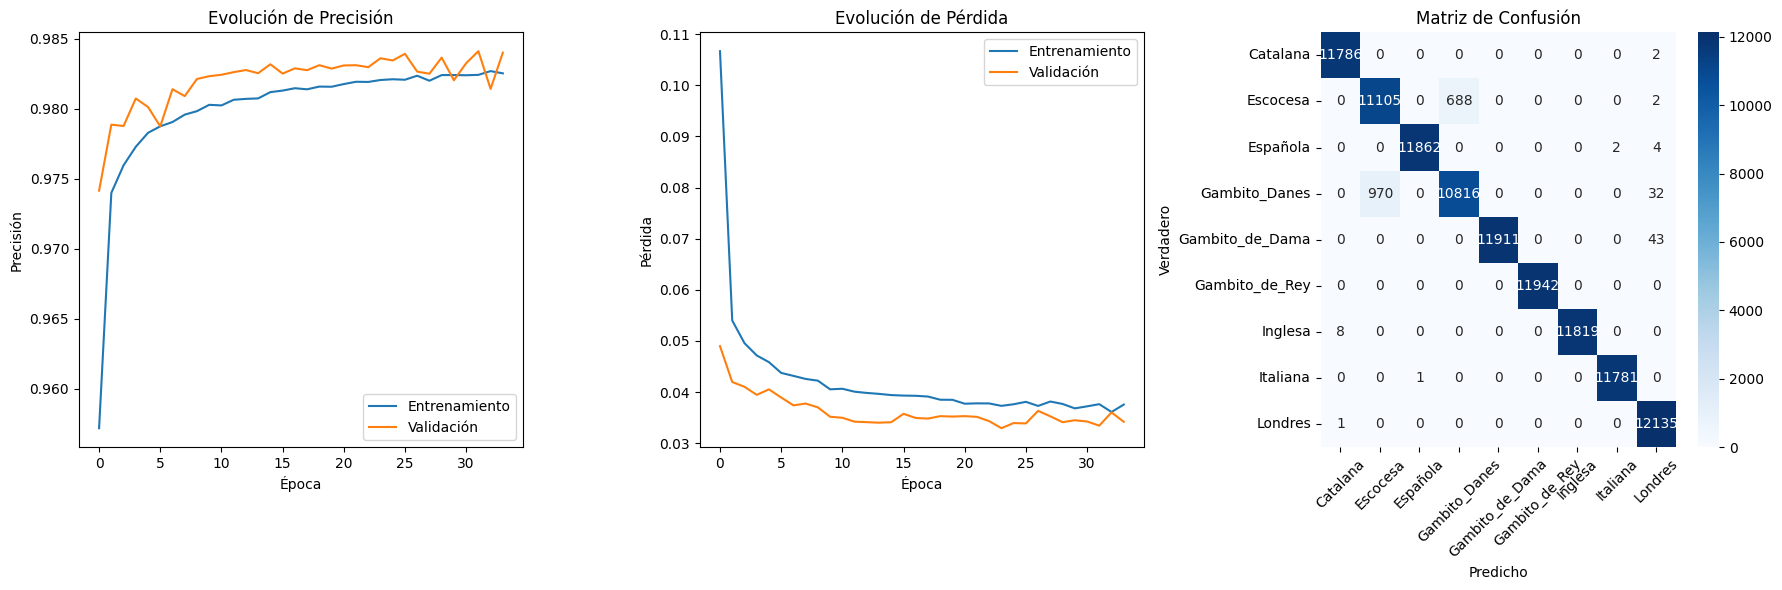

Modelo guardado como opening_recommender_model.keras


In [ ]:
recommender = OpeningRecommender()
if recommender.process_pgns():
  recommender.train_model()
  recommender.save_model("opening_recommender_model")

In [63]:
model = OpeningRecommender.load_model("opening_recommender_model")

pgn = """
[Event "rated blitz game"]
[Site "https://lichess.org/AtwDAwKW"]
[Date "2025.06.12"]
[White "fredgra2"]
[Black "captain_quesillo"]
[Result "1-0"]
[GameId "AtwDAwKW"]
[UTCDate "2025.06.12"]
[UTCTime "05:09:38"]
[WhiteElo "2182"]
[BlackElo "2035"]
[WhiteRatingDiff "+4"]
[BlackRatingDiff "-3"]
[WhiteTitle "CM"]
[Variant "Standard"]
[TimeControl "180+0"]
[ECO "B21"]
[Opening "Sicilian Defense: Smith-Morra Gambit Accepted"]
[Termination "Normal"]
[Annotator "lichess.org"]

1. e4 { [%eval 0.18] [%clk 0:03:00] } 1... c5 { [%eval 0.25] [%clk 0:03:00] } 2. d4 { [%eval 0.05] [%clk 0:02:59] } 2... cxd4 { [%eval 0.02] [%clk 0:02:59] } 3. c3 { [%eval -0.09] [%clk 0:02:59] } 3... dxc3 { [%eval -0.12] [%clk 0:02:58] } { B21 Sicilian Defense: Smith-Morra Gambit Accepted } 4. Nxc3 { [%eval -0.22] [%clk 0:02:59] } 4... g6 { [%eval 0.0] [%clk 0:02:57] } 5. Nf3 { [%eval 0.0] [%clk 0:02:58] } 5... Bg7 { [%eval 0.0] [%clk 0:02:56] } 6. h4 { [%eval -0.5] [%clk 0:02:58] } 6... a6? { (-0.50 → 0.80) Mistake. Nf6 was best. } { [%eval 0.8] [%clk 0:02:56] } (6... Nf6 7. Qa4 Ng4 8. h5 Qb6 9. Qc2 Nc6 10. h6 Bf6 11. Qd2) 7. h5 { [%eval 1.04] [%clk 0:02:56] } 7... e6 { [%eval 1.36] [%clk 0:02:48] } 8. Bg5 { [%eval 1.06] [%clk 0:02:50] } 8... Qa5 { [%eval 1.34] [%clk 0:02:43] } 9. h6 { [%eval 1.36] [%clk 0:02:41] } 9... Bxc3+ { [%eval 1.29] [%clk 0:02:38] } 10. bxc3 { [%eval 1.32] [%clk 0:02:39] } 10... Qxc3+ { [%eval 1.57] [%clk 0:02:37] } 11. Bd2 { [%eval 1.67] [%clk 0:02:38] } 11... Qc6 { [%eval 2.22] [%clk 0:02:33] } 12. Rc1?! { (2.22 → 1.09) Inaccuracy. Be2 was best. } { [%eval 1.09] [%clk 0:02:35] } (12. Be2 Qd6 13. e5 Qf8 14. Ng5 f5 15. exf6 Nxf6 16. Rc1 Nc6 17. O-O d5) 12... Qxe4+ { [%eval 1.36] [%clk 0:02:32] } 13. Be2 { [%eval 0.51] [%clk 0:02:28] } 13... Ne7?? { (0.51 → 2.74) Blunder. Nc6 was best. } { [%eval 2.74] [%clk 0:02:31] } (13... Nc6 14. Bc3 f6 15. Rh4 Qd5 16. Nd2 Qd6 17. a4 b5 18. Bf3 Nge7 19. Bxf6) 14. Rh4 { [%eval 3.04] [%clk 0:02:18] } 14... Qf5 { [%eval 2.86] [%clk 0:02:21] } 15. Nd4?? { (2.86 → 0.15) Blunder. Rd4 was best. } { [%eval 0.15] [%clk 0:01:35] } (15. Rd4 e5 16. g4 Qe6 17. Ng5 exd4 18. Nxe6 fxe6 19. Bb4 Nbc6 20. Bd6 b5) 15... Qf6? { (0.15 → 1.53) Mistake. Qd5 was best. } { [%eval 1.53] [%clk 0:02:17] } (15... Qd5 16. Bf3) 16. Nf3 { [%eval 1.56] [%clk 0:01:29] } 16... O-O?? { (1.56 → 4.72) Blunder. Nbc6 was best. } { [%eval 4.72] [%clk 0:02:15] } (16... Nbc6 17. Rf4 Nf5 18. g4 e5 19. gxf5 gxf5 20. Rh4 Rg8 21. Rh5 d5 22. Qb3) 17. Bc3? { (4.72 → 2.93) Mistake. Bg5 was best. } { [%eval 2.93] [%clk 0:01:13] } (17. Bg5 Qh8 18. Bxe7 Re8 19. Rf4 f5 20. Bb4 Nc6 21. Bc3 e5 22. Ng5 Qf6) 17... Qf5 { [%eval 1.2] [%clk 0:02:12] } 18. Bd3 { [%eval 0.81] [%clk 0:01:01] } 18... Qd5 { [%eval 0.66] [%clk 0:02:00] } 19. Rd4 { [%eval 0.67] [%clk 0:00:57] } 19... Qh5 { [%eval 0.86] [%clk 0:01:56] } 20. Rh4 { [%eval 0.92] [%clk 0:00:51] } 20... Qd5 { [%eval 0.82] [%clk 0:01:54] } 21. Bg7 { [%eval 0.59] [%clk 0:00:41] } 21... Nf5?? { (0.59 → 4.54) Blunder. Re8 was best. } { [%eval 4.54] [%clk 0:01:42] } (21... Re8 22. Qd2) 22. Bxf5 { [%eval 4.08] [%clk 0:00:32] } 22... Qxd1+ { [%eval 4.02] [%clk 0:01:40] } 23. Kxd1 { [%eval 3.99] [%clk 0:00:31] } 23... exf5?! { (3.99 → 5.01) Inaccuracy. Re8 was best. } { [%eval 5.01] [%clk 0:01:38] } (23... Re8 24. Bc2 Nc6 25. Kd2 b5 26. Ng5 f5 27. g4 Na5 28. gxf5 exf5 29. Bb3+) 24. Bxf8 { [%eval 4.97] [%clk 0:00:30] } 24... Kxf8?! { (4.97 → 7.99) Inaccuracy. Nc6 was best. } { [%eval 7.99] [%clk 0:01:37] } (24... Nc6 25. Bg7 b5 26. Bf6 Bb7 27. Ng5 Na5 28. Rc7 Bc6 29. Rd4 Nc4 30. Rdxd7) 25. Rxc8+ { [%eval 7.95] [%clk 0:00:29] } 25... Ke7 { [%eval 7.8] [%clk 0:01:36] } 26. Ng5 { [%eval 7.93] [%clk 0:00:28] } 26... a5 { [%eval 7.61] [%clk 0:01:27] } 27. Nxh7 { [%eval 7.24] [%clk 0:00:26] } 27... d6 { [%eval 8.9] [%clk 0:01:16] } 28. Ng5 { [%eval 8.8] [%clk 0:00:24] } 28... Kd7 { [%eval 9.71] [%clk 0:01:15] } 29. h7 { [%eval 9.71] [%clk 0:00:21] } 29... Kxc8 { [%eval 10.07] [%clk 0:01:13] } 30. h8=Q+ { [%eval 9.83] [%clk 0:00:20] } 30... Kc7 { [%eval 9.24] [%clk 0:01:13] } 31. Nxf7 { [%eval 9.06] [%clk 0:00:19] } 31... Kb6? { (9.06 → Mate in 7) Checkmate is now unavoidable. Nc6 was best. } { [%eval #7] [%clk 0:01:12] } (31... Nc6 32. Qxa8 Kb6 33. Nd8 Nxd8 34. Qxd8+ Kc6 35. Qc8+ Kd5 36. Qd7 Ke5 37. Qe7+) 32. Qd8+ { [%eval #6] [%clk 0:00:17] } 32... Ka7 { [%eval #6] [%clk 0:01:10] } 33. Rh8?! { (Mate in 6 → 12.91) Lost forced checkmate sequence. Nxd6 was best. } { [%eval 12.91] [%clk 0:00:17] } (33. Nxd6 Nc6 34. Qc7 Rb8 35. Rh8 f4 36. Rxb8 Nd8 37. Rxd8 g5 38. Qxb7#) 33... Ka6?! { (12.91 → Mate in 5) Checkmate is now unavoidable. Na6 was best. } { [%eval #5] [%clk 0:01:07] } (33... Na6 34. Qxa8+) 34. Nxd6 { [%eval #4] [%clk 0:00:15] } 34... Nc6 { [%eval #4] [%clk 0:01:03] } 35. Qxa8+ { [%eval #6] [%clk 0:00:13] } 35... Kb6 { [%eval #6] [%clk 0:01:02] } 36. Qxb7+ { [%eval #5] [%clk 0:00:12] } { Black resigns. } 1-0



"""

recommendations = model.recommend_for_pgn(pgn, player_style="combinativo")

if isinstance(recommendations, str):
    print(f"Error: {recommendations}")
else:
    for i, apertura in enumerate(recommendations, 1):
        print(f"{i}. {apertura['apertura']} - Estilo: {apertura['estilo']} - Prob: {apertura['probabilidad']:.2%}")

Modelo cargado desde opening_recommender_model.keras
1. Escocesa - Estilo: combinativo - Prob: 100.00%
2. Gambito_Danes - Estilo: combinativo - Prob: 0.00%
3. Inglesa - Estilo: posicional - Prob: 0.00%
